Merging clusters:
Index(['A', 'B'], dtype='object')
Distance:
0.5
Merging clusters:
Index(['E', 'F'], dtype='object')
Distance:
1.0
Merging clusters:
Index(['('A', 'B')', 'C'], dtype='object')
Distance:
1.25
Merging clusters:
Index(['("('A', 'B')", 'C')', 'D'], dtype='object')
Distance:
2.625
Merging clusters:
Index(['('("(\'A\', \'B\')", \'C\')', 'D')', '('E', 'F')'], dtype='object')
Distance:
6.8125


C:\Users\dhira\anaconda3\lib\site-packages\ipykernel_launcher.py:188: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


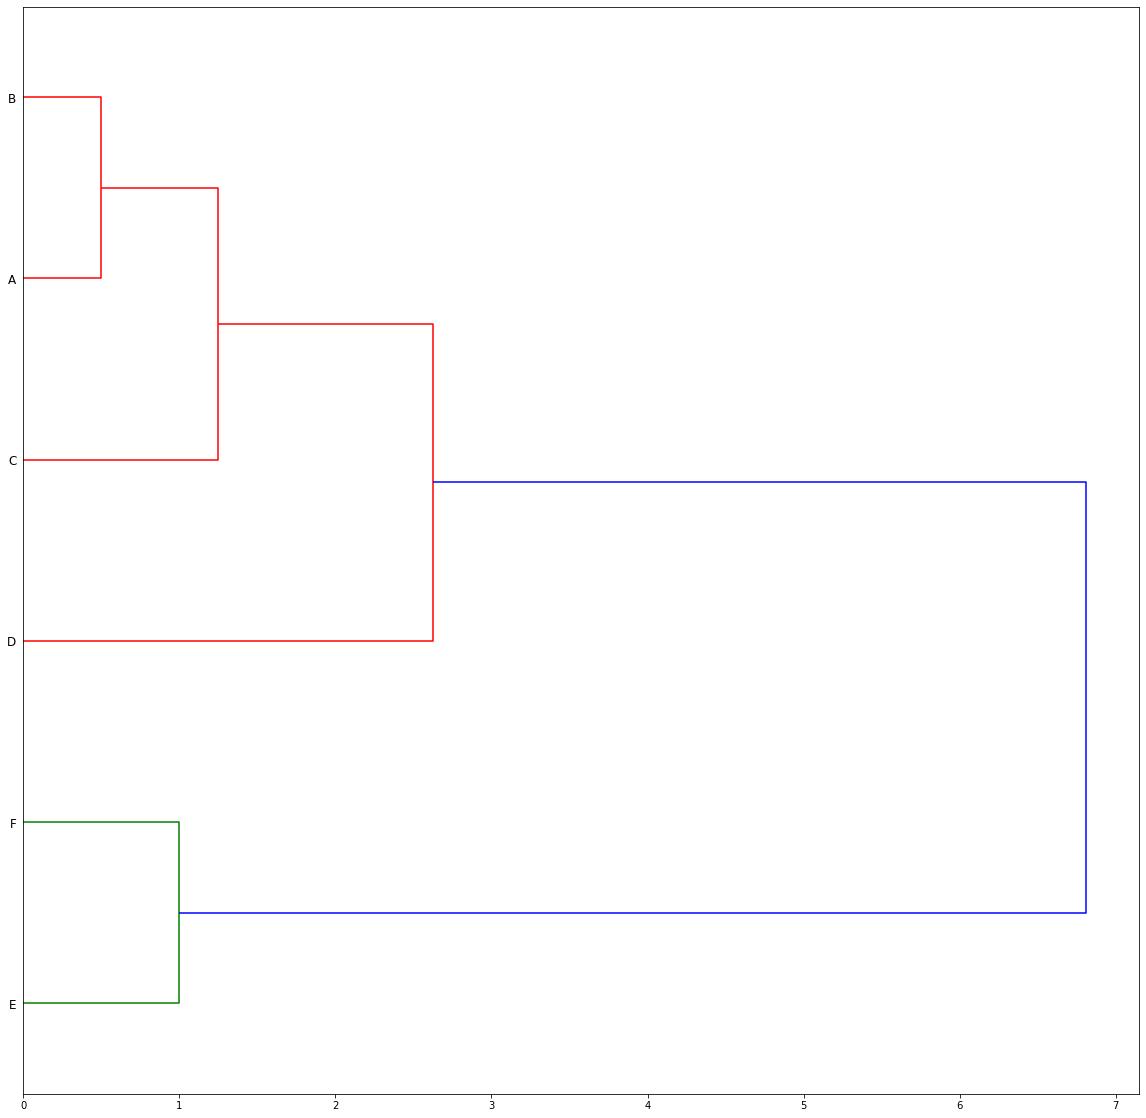

In [33]:
#try2

from matplotlib.pyplot import subplots
from numpy import where
from pandas import DataFrame, IndexSlice
from scipy.cluster.hierarchy import average, dendrogram
from scipy.spatial.distance import squareform
from seaborn import light_palette
import os

class UPGMA:
    def __init__(self, upgma):
        # 1. Initialize phylogeny and record dictionaries.
        '''
        The constructor requires a dataframe.
        In addition, two dictionaries are created:
        1. upgma_records: Highlighted tables.
        2. phylogeny: Tree distance between clusters.
        For the final dendrogram, cluster labels are
        the original index, while a condensed distance
        matrix is required for scipy
        '''
        self.upgma = upgma.copy()
        self.cluster_labels = self.upgma.index
        self.condensed_upgma = average(squareform(upgma.values))
        self.upgma_records, self.phylogeny = {}, {}

    def calc_most_related(self):
        # 2. Get the minimum two pair sums for each animal.
        '''
        Use a dict comphrension to get the minimal
        distance between each animal.
        This is done by taking the two smallest values
        per index and summing them.
        '''
        self.most_related = {
            animal: self.upgma[animal].nsmallest(n=2).sum()
            for animal in self.upgma.index
        }

    def calc_selected_min(self):
        # 3. Get the lowest minimum from the most related pairs.
        '''
        Return the lowest minimum value from the most related dict.
        '''
        self.selected_min = min(self.most_related.values())

    def add_upgma_gradient(self):
        # 4. Add gradient
        '''
        The largest values will cluster last,
        while the lowest values besides zero will
        cluster first.
        '''
        self.upgma_style = self.upgma.copy().style.background_gradient(
            cmap=light_palette('indigo', as_cmap=True))

    def get_min_indices(self):
        # 5. Get the indices for the selected min.
        '''
        Retrive indices where the selected min exists.
        Also create a tuple of this index for future use
        as dictonary keys and dataframe indices.
        '''
        self.min_index = self.upgma.iloc[where(
            self.upgma == self.selected_min)].index
        self.min_pair = str(tuple(self.min_index))
        #print(self.min_pair)

    def update_phylogeny(self):
        # 6. Save the minimum pair to the phylogeny dictionary.
        '''
        This dictionary will be used to build the tree.
        The horizontal distance between the animals is calculated
        by dividing the lowest min by 2.
        '''
        self.phylogeny[self.min_pair] = self.selected_min / 2
        #print(self.phylogeny[self.min_pair])

    def highlight_merging_cells(self):
        # 7. Highlights indices to merge.
        '''
        All parallel elements will be added together and
        divided by 2.
        '''
        self.upgma_style.applymap(lambda x: 'background-color: yellow',
                                  subset=IndexSlice[self.min_index, :])
        self.upgma_style.applymap(lambda x: 'background-color: yellow',
                                  subset=IndexSlice[:, self.min_index])

    def highlight_min_cells(self):
        # 8. Highlights the mins.
        '''
        After getting the minimum difference,
        highlight the cells that
        match the overall minimum result.
        '''
        self.upgma_style.applymap(
            lambda x: 'background-color: red',
            subset=IndexSlice[self.min_index, self.min_index])

    def update_upgma_records(self):
        # 9. Add the stylized frame to the style dictionary.
        '''
        All steps of the tabular process are recorded
        '''
        self.upgma_records[self.min_pair] = self.upgma_style

    def calc_upgma_cluster(self):
        # 10. Calculate the values for the affected cells.
        '''
        Perform vectorized addition between cells that will
        be merged then divide by two.
        '''
        self.merged_results = self.upgma.loc[self.min_index, :].sum() / 2
        self.merged_results.drop(self.min_index, inplace=True)
        print("Merging clusters:")
        print(self.min_index)
        print("Distance:")
        print(self.phylogeny[self.min_pair])

    def restruct_upgma(self):
        # 11. Restructure the upgma dataframe.
        '''
        Update the dataframe with the clustered index
        names, then drop the unclustered index names.
        '''
        self.upgma.rename(columns={self.min_index[0]: self.min_pair},
                          index={self.min_index[0]: self.min_pair},
                          inplace=True)
        self.upgma.drop(self.min_index[1], axis=0, inplace=True)
        self.upgma.drop(self.min_index[1], axis=1, inplace=True)

    def upgma_merge_cluster(self):
        # 12. Update the upgma values.
        '''
        Now substitute the merged values along the clustered
        axes.
        '''
        self.upgma.loc[self.upgma[self.min_pair] > 0, self.
                       min_pair] = self.merged_results
        self.upgma.loc[self.min_pair, self.
                       upgma[self.min_pair] > 0] = self.merged_results

    def run_upgma(self):
        # 13. Run the algorithm.
        '''
        All steps will be saved to their respective dictionaries.
        Indices will be tupled and nested to construct the tree
        in the phylogeny dictionary,
        while the final highlighted tables for each iteration
        are stored in the upgma_records dictionary.
        '''
        while self.upgma.shape != (1, 1):
            self.calc_most_related()
            self.calc_selected_min()
            self.add_upgma_gradient()
            self.get_min_indices()
            self.update_phylogeny()
            self.highlight_merging_cells()
            self.highlight_min_cells()
            self.update_upgma_records()
            self.calc_upgma_cluster()
            self.restruct_upgma()
            self.upgma_merge_cluster()

    def finalize_distances(self):
        # 14. Remove condensed scaling
        '''
        The form of the condensed distance matrix is preserved,
        but the scaling is unwanted and removed.
        '''
        self.condensed_upgma[:, 2] = list(self.phylogeny.values())
        #print(self.condensed_upgma[:,2])

    def plot_upgma(self):
        # 15. Plot the dendrogram
        '''
        The final results are displayed here, using
        the original index labels from the original
        full distance matrix dataframe.
        '''
        fig, ax = subplots(figsize=(20, 20))
        dendrogram(self.condensed_upgma,
                   ax=ax,
                   orientation='right',
                   labels=self.cluster_labels)
        fig.show()


# for input Just change the file path (make sure it is similar to the sample input given)
path= os.path.abspath('C:\\Users\\dhira\\Desktop\\upwork\\DM-p127.txt')

f = open(path, 'r')
d=[]
di={}
for i in f:
    d.append(i.strip())
n= int(d[0])
key= d[1].split()
val=[]
for j in range(2,n+2):
    val.append(d[j].split())

for i in range(n):
    for j in range(n):
        val[i][j]= int(val[i][j])

for i in range(n):
    di[key[i]]= val[i]
    
inp_df= DataFrame(di, index=di.keys())
upgma= UPGMA(inp_df)
        
        
# %% Uncomment below and run repeatedly to print the highlighted dataframes

upgma.calc_most_related()
upgma.calc_selected_min()
upgma.add_upgma_gradient()
upgma.get_min_indices()
upgma.update_phylogeny()
upgma.highlight_merging_cells()
upgma.highlight_min_cells()
upgma.update_upgma_records()
upgma.calc_upgma_cluster()
upgma.restruct_upgma()
upgma.upgma_merge_cluster()
upgma.upgma_style


# %% Run everything by default
upgma.run_upgma()

# %% Plot the dendrogram
upgma.finalize_distances()
upgma.plot_upgma()